# Anak Agung Ngurah Bagus Trihatmaja

Implement a Feed Forward Neural Network in Python, with an input layer with $S_1$ units, one hidden layer with $S_2$ units, and an output layer with $S_3$ units using the back-propagation algorithm.  The network will be trained using data $\{(x^i, y^i)\}^N_{i=1}$ for $x^i ∈ \mathbb{R}^{S_1}$ and $y^i ∈ \mathbb{R}^{S_3}$. The code must allow specifying the following activation functions: sigmoid, hyperbolic tangent and rectifier linear activation. The code must output all the
learned weights and biasses of all layers as well as the activations of the last layer


Feature checklists:

1. The code must allow specifying the following activation functions: sigmoid, hyperbolic tangent and rectifier linear activation.
2. The code must output all the learned weights and biasses of all layers as well as the activations of the last layer

In [1]:
%run helper.py

import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import scipy.io

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Plotting the training dataset
# Load dataset 1
ds1 = scipy.io.loadmat('dataset.mat')
ds1_train_X = ds1['X_train']
ds1_test_X = ds1['X_test']
ds1_train_Y = ds1['Y_train']
ds1_test_Y = ds1['Y_test']

ds1_validation_X = ds1['X_validation']
ds1_validation_Y = ds1['Y_validation']

# The dimension is weird, it seems like it has 200 columns, I think we need to transpose it
ds1_train_X = ds1_train_X.T
ds1_train_Y = ds1_train_Y.T
ds1_test_X = ds1_test_X.T
ds1_test_Y = ds1_test_Y.T
ds1_validation_X = ds1_validation_X.T
ds1_validation_Y = ds1_validation_Y.T


X = ds1_train_X.T
y = ds1_train_Y.T[0]

# Combine them all into one data frame
ds1_train = to_data_frame(ds1_train_X, ds1_train_Y)

In [32]:
# List of activation functions

%run activation_functions.py


$S_1$ is the number of unit in layer 1 (input layer), it consists of the features we have, in this case we have $x_1$ and $x_2$, therefore the value of $S_1$ is 2 (not counting bias unit).

$S_3$ is the number of unit in layer 3 (output layer), in this case the value of $S_3$ is 2, because in our implementation we are giving the probability.


Let $S_2 = 2$. Train the neural network on the provided training data for several values of the regularization $\lambda$. Report the classification error on the validation dataset for each $\lambda$ and report the best $\lambda$ that achieves the minimum validation error.  For this $\lambda$, report the classification error on the training and also on the test datasets.

In [33]:
n_samples = len(ds1_train_X)
nn_input_dimension = ds1_train_X.shape[1]
nn_output_dimension = ds1_train_X.shape[1]


learning_rate = 0.01 # Learning rate for gradient descent
lambd = 1e-15 # Regularization 

# Helper functions
def calculate_loss(X, y, model, lambd, activation_function = "tanh"):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    
    
    if activation_function == "relu":
        a1 = relu(z1)
    elif activation_function == "sigmoid":
        a1 = sigmoid(z1)
    elif activation_function == "softplus":
        a1 = softplus(z1)
    else:
        a1 = tanh(z1)
    
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(n_samples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += lambd / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1. / n_samples * data_loss

# Helper function to predict an output (0 or 1)
def predict(model, x, activation_function = "tanh"):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    
    if activation_function == "relu":
        a1 = relu(z1)
    elif activation_function == "sigmoid":
        a1 = sigmoid(z1)
    elif activation_function == "softplus":
        a1 = softplus(z1)
    else:
        a1 = tanh(z1)
        
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)


def build_model(X, y, nn_hdim, lambd, num_passes=20000, print_loss=False, activation_function = "tanh"):
     
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dimension, nn_hdim) / np.sqrt(nn_input_dimension)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dimension) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dimension))
 
    # This is what we return at the end
    model = {}
     
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
 
        # Forward propagation
        z1 = X.dot(W1) + b1
         
        if activation_function == "relu":
            a1 = relu(z1)
        elif activation_function == "logistic":
            a1 = logistic(z1)
        elif activation_function == "softplus":
            a1 = softplus(z1)
        else:
            a1 = tanh(z1)
        
        
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
 
        # Backpropagation
        delta3 = probs
        delta3[range(n_samples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        
        if activation_function == "relu":
            delta2 = delta3.dot(W2.T) * relu_derivative(z1)
        elif activation_function == "logistic":
            delta2 = delta3.dot(W2.T) * logistic_derivative(z1)
        elif activation_function == "softplus":
            delta2 = delta3.dot(W2.T) * softplus_derivative(z1)
        else:
            delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += lambd * W2
        dW1 += lambd * W1
 
        # Gradient descent parameter update
        W1 += -learning_rate * dW1
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
         
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'a1': a1}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(X, y, model, lambd)))
     
    return model

In [34]:
# Print the result
X = ds1_train_X
y = ds1_train_Y.T[0]


model = build_model(X, y, 2, 0.01, print_loss=False, activation_function = "logistic")
print(model)

{'W1': array([[ 6.47890306, -5.88040485],
       [-6.38714337,  6.0416538 ]]), 'b1': array([[ 3.2474331 ,  3.07930255]]), 'W2': array([[ 7.85358262, -7.76839446],
       [ 7.86513559, -7.78870746]]), 'b2': array([[-11.63677242,  11.63677242]]), 'a1': array([[ 0.92225502,  0.97779154],
       [ 0.99027583,  0.86008625],
       [ 0.9748647 ,  0.93713592],
       [ 0.95802077,  0.95992911],
       [ 0.98500486,  0.90156306],
       [ 0.94332579,  0.97094362],
       [ 0.98009714,  0.92297646],
       [ 0.88323364,  0.98536053],
       [ 0.88087898,  0.98587189],
       [ 0.98770365,  0.8822404 ],
       [ 0.98353623,  0.90807423],
       [ 0.93340621,  0.97501469],
       [ 0.96075019,  0.95655436],
       [ 0.90039729,  0.98261495],
       [ 0.96085564,  0.95774935],
       [ 0.99269426,  0.82379112],
       [ 0.95973965,  0.95987226],
       [ 0.98272124,  0.91563451],
       [ 0.98873109,  0.8710712 ],
       [ 0.97897378,  0.9269824 ],
       [ 0.87062844,  0.98714021],
       [ 0.790

In [35]:
def calculate_error(predicted, real):
    count = 0
    for i in range(0, len(predicted)):
        if predicted[i] != real.T[0][i]:
            count += 1
        
    return count / len(predicted) * 100
    
    
def generate_prediction(model, X, activation_function = "tanh"):
    result = []
    for x in X:
        result.append(predict(model, x, activation_function)[0])   
    return result


In [36]:
def get_minimum_error(activation_function = "tanh", number_of_neuron = 2):
    X = ds1_train_X
    y = ds1_train_Y.T[0]

    lambd = 1e-3
    min_lambd = 1000000000000
    min_error = 999999999999999
    while lambd < 1e3:
        model = build_model(X, y, number_of_neuron, lambd, print_loss=False, activation_function = activation_function)
        result = generate_prediction(model, ds1_validation_X, activation_function = activation_function)
        
        error = calculate_error(result, ds1_validation_Y)
        print("Lambda: %s, Error: %s" % (lambd, error))
        if error < min_error:
            min_error = error
            min_lambd = lambd
            
        lambd = lambd * 10 
    
    return min_error, min_lambd


In [37]:
print("Activation function: tanh. Minimum error is %s for lambda: %s" % get_minimum_error("tanh"))

Lambda: 0.001, Error: 0.0
Lambda: 0.01, Error: 0.0
Lambda: 0.1, Error: 0.0
Lambda: 1.0, Error: 0.0
Lambda: 10.0, Error: 50.0
Lambda: 100.0, Error: 50.0
Activation function: tanh. Minimum error is 0.0 for lambda: 0.001


In [38]:
print("Activation function: logistic. Minimum error is %s for lambda: %s" % get_minimum_error("logistic"))

Lambda: 0.001, Error: 0.0
Lambda: 0.01, Error: 0.0
Lambda: 0.1, Error: 0.0
Lambda: 1.0, Error: 50.0
Lambda: 10.0, Error: 50.0
Lambda: 100.0, Error: 50.0
Activation function: logistic. Minimum error is 0.0 for lambda: 0.001


In [39]:
print("Activation function: relu. Minimum error is %s for lambda: %s" % get_minimum_error("relu"))

Lambda: 0.001, Error: 25.0
Lambda: 0.01, Error: 25.0
Lambda: 0.1, Error: 25.0
Lambda: 1.0, Error: 25.0
Lambda: 10.0, Error: 50.0
Lambda: 100.0, Error: 50.0
Activation function: relu. Minimum error is 25.0 for lambda: 0.001


In [40]:
print("Activation function: softplus. Minimum error is %s for lambda: %s" % get_minimum_error("softplus"))

Lambda: 0.001, Error: 0.0
Lambda: 0.01, Error: 0.0
Lambda: 0.1, Error: 0.0
Lambda: 1.0, Error: 0.0
Lambda: 10.0, Error: 50.0
Lambda: 100.0, Error: 50.0
Activation function: softplus. Minimum error is 0.0 for lambda: 0.001


In [62]:
# Tanh on training dataset
model = build_model(X, y, 2, 1e-3, print_loss=False, activation_function = "tanh")
result = generate_prediction(model, ds1_train_X, activation_function = "tanh")  
calculate_error(result, ds1_train_Y)

0.0

In [63]:
# Logistic on training dataset
model = build_model(X, y, 2, 1e-3, print_loss=False, activation_function = "logistic")
result = generate_prediction(model, ds1_train_X, activation_function = "logistic")  
calculate_error(result, ds1_train_Y)

0.0

In [64]:
# Relu on training dataset
model = build_model(X, y, 2, 1e-3, print_loss=False, activation_function = "relu")
result = generate_prediction(model, ds1_train_X, activation_function = "relu")  
calculate_error(result, ds1_train_Y)

25.0

In [65]:
# Softplus on training dataset
model = build_model(X, y, 2, 1e-3, print_loss=False, activation_function = "softplus")
result = generate_prediction(model, ds1_train_X, activation_function = "softplus")  
calculate_error(result, ds1_train_Y)

0.0

In [66]:
# Tanh on testing dataset
model = build_model(X, y, 2, 1e-3, print_loss=False, activation_function = "tanh")
result = generate_prediction(model, ds1_test_X, activation_function = "tanh")  
calculate_error(result, ds1_test_Y)

0.0

In [67]:
# Logistic on testing dataset
model = build_model(X, y, 2, 1e-3, print_loss=False, activation_function = "logistic")
result = generate_prediction(model, ds1_test_X, activation_function = "logistic")  
calculate_error(result, ds1_test_Y)

0.0

In [68]:
# Relu on testing dataset
model = build_model(X, y, 2, 1e-3, print_loss=False, activation_function = "relu")
result = generate_prediction(model, ds1_test_X, activation_function = "relu")  
calculate_error(result, ds1_test_Y)

25.0

In [69]:
# Softplus on testing dataset
model = build_model(X, y, 2, 1e-3, print_loss=False, activation_function = "softplus")
result = generate_prediction(model, ds1_test_X, activation_function = "softplus")  
calculate_error(result, ds1_test_Y)

0.0

In [70]:
# For double checking our result, we use neural network from Sklearn

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10), random_state=1, activation="relu")

clf.fit(X, y)
print(clf.predict(ds1_test_X))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


## Problem 3.3

Repeat part (ii) for $S_2 = 10$.

In [71]:
print("Activation function: tanh. Minimum error is %s for lambda: %s" % get_minimum_error("tanh", 10))
print("Activation function: logistic. Minimum error is %s for lambda: %s" % get_minimum_error("logistic", 10))
print("Activation function: relu. Minimum error is %s for lambda: %s" % get_minimum_error("relu", 10))
print("Activation function: softplus. Minimum error is %s for lambda: %s" % get_minimum_error("softplus", 10))

Lambda: 0.001, Error: 0.0
Lambda: 0.01, Error: 0.0
Lambda: 0.1, Error: 0.0
Lambda: 1.0, Error: 0.0
Lambda: 10.0, Error: 50.0
Lambda: 100.0, Error: 50.0
Activation function: tanh. Minimum error is 0.0 for lambda: 0.001
Lambda: 0.001, Error: 0.0
Lambda: 0.01, Error: 0.0
Lambda: 0.1, Error: 0.0
Lambda: 1.0, Error: 50.0
Lambda: 10.0, Error: 50.0
Lambda: 100.0, Error: 50.0
Activation function: logistic. Minimum error is 0.0 for lambda: 0.001
Lambda: 0.001, Error: 0.0
Lambda: 0.01, Error: 0.0
Lambda: 0.1, Error: 0.0
Lambda: 1.0, Error: 0.0
Lambda: 10.0, Error: 42.5
Lambda: 100.0, Error: 50.0
Activation function: relu. Minimum error is 0.0 for lambda: 0.001
Lambda: 0.001, Error: 0.0
Lambda: 0.01, Error: 0.0
Lambda: 0.1, Error: 0.0
Lambda: 1.0, Error: 0.0
Lambda: 10.0, Error: 50.0
Lambda: 100.0, Error: 50.0
Activation function: softplus. Minimum error is 0.0 for lambda: 0.001


In [72]:
# Tanh on training dataset
model = build_model(X, y, 10, 1e-3, print_loss=False, activation_function = "tanh")
result = generate_prediction(model, ds1_train_X)  
calculate_error(result, ds1_train_Y)

0.0

In [73]:
# Logistic on training dataset
model = build_model(X, y, 10, 1e-3, print_loss=False, activation_function = "logistic")
result = generate_prediction(model, ds1_train_X)  
calculate_error(result, ds1_train_Y)

0.0

In [74]:
# Relu on training dataset
model = build_model(X, y, 10, 1e-3, print_loss=False, activation_function = "relu")
result = generate_prediction(model, ds1_train_X)  
calculate_error(result, ds1_train_Y)

50.0

In [75]:
# Softplus on training dataset
model = build_model(X, y, 10, 1e-3, print_loss=False, activation_function = "softplus")
result = generate_prediction(model, ds1_train_X)  
calculate_error(result, ds1_train_Y)

50.5

In [76]:
# Tanh on testing dataset
model = build_model(X, y, 10, 1e-3, print_loss=False, activation_function = "tanh")
result = generate_prediction(model, ds1_test_X)  
calculate_error(result, ds1_test_Y)

0.0

In [77]:
# Logistic on testing dataset
model = build_model(X, y, 10, 1e-3, print_loss=False, activation_function = "logistic")
result = generate_prediction(model, ds1_test_X)  
calculate_error(result, ds1_test_Y)

0.0

In [78]:
# Relu on testing dataset
model = build_model(X, y, 10, 1e-3, print_loss=False, activation_function = "relu")
result = generate_prediction(model, ds1_test_X)  
calculate_error(result, ds1_test_Y)

50.0

In [79]:
# Softplus on testing dataset
model = build_model(X, y, 10, 1e-3, print_loss=False, activation_function = "softplus")
result = generate_prediction(model, ds1_test_X)  
calculate_error(result, ds1_test_Y)

48.333333333333336

## Problem 3.4

Plot the input training data, so that points in class 1 are denoted by blue circles and points
in class 0 are denoted by red squares.

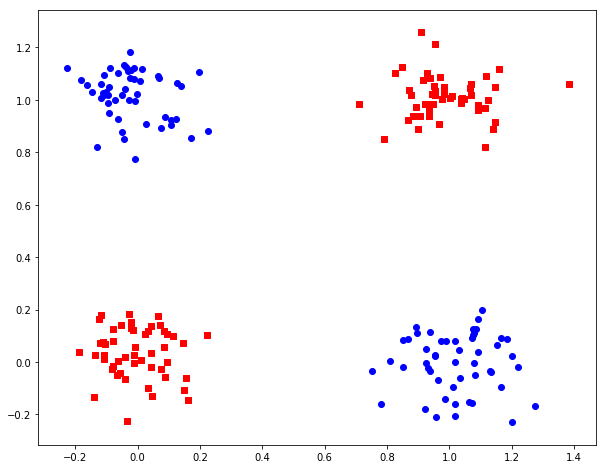

In [80]:
# Plot the graph

for x1, x2, klass in zip(ds1_train['x1'], ds1_train['x2'], ds1_train['y']):
    if klass == 1:
        plt.scatter(x1, x2, c = 'blue', marker = 'o')
    else:
        plt.scatter(x1, x2, c = 'red', marker = 's')
    
plt.show()

In [86]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

> Is this dataset linearly separable? 

From the plot above, we can see that the data is not linearly separable (we need at least two lines to make them linearly separable).

> Could either of the neural networks in part (ii) or (iii) correctly classify this data? Explain.



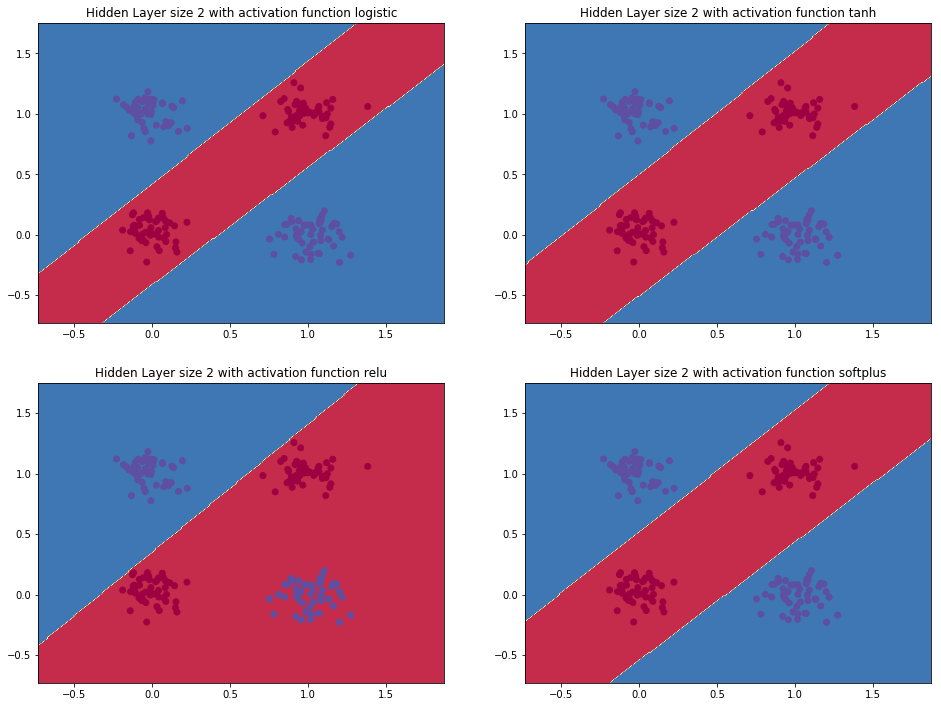

In [87]:
plt.figure(figsize=(16, 32))
activation_functions = ["logistic", "tanh", "relu", "softplus"]
for i, activation_function in enumerate(activation_functions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d with activation function %s' % (2, activation_function))
    model = build_model(X, y, 2, 0.01, print_loss=False, activation_function = activation_function)
    plot_decision_boundary(lambda x: predict(model, x, activation_function))
plt.show()

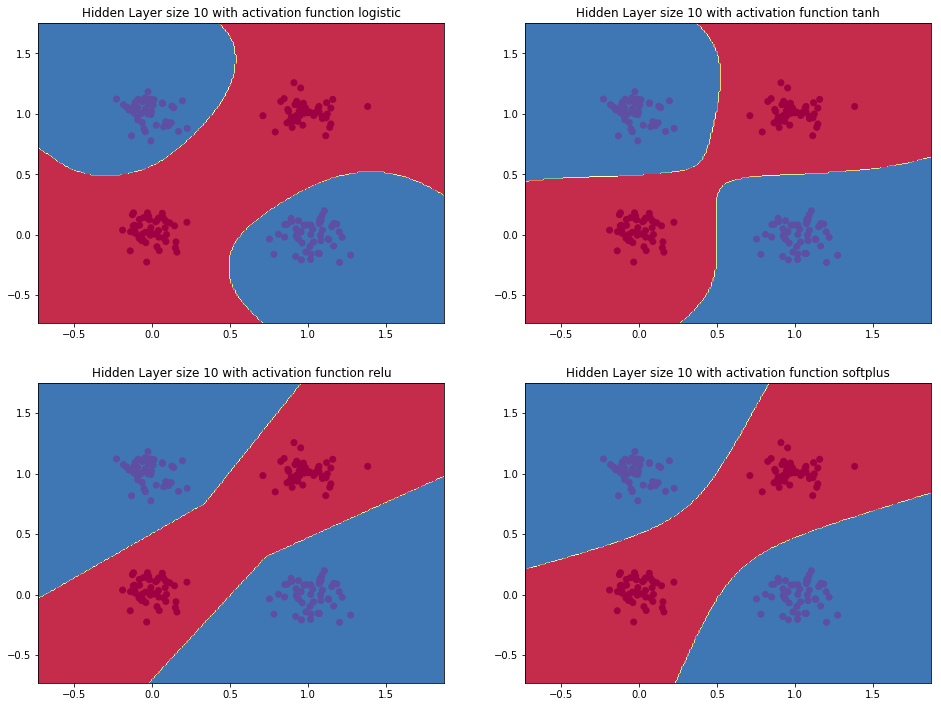

In [88]:
plt.figure(figsize=(16, 32))
activation_functions = ["logistic", "tanh", "relu", "softplus"]
for i, activation_function in enumerate(activation_functions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d with activation function %s' % (10, activation_function))
    model = build_model(X, y, 10, 0.01, print_loss=False, activation_function = activation_function)
    plot_decision_boundary(lambda x: predict(model, x, activation_function))
plt.show()

Yes, from the plot we can see that we can separate the training data using neural network. Relu has less accuracy on training dataset if the number of nodes is 2 but if the number of nodes in hidden layer is big enough relu can also correctly clasify the training dataset.